# Dadbot: Dad's memorial bot based on RASA (old style)

## Starting Jupyter Notebook with necessary imports

In [1]:
%matplotlib inline

import logging, io, json, warnings
logging.basicConfig(level="INFO")
warnings.filterwarnings('ignore')


# Installations
* Rasa
* SpaCy Language Model

In [2]:
import sys
python = sys.executable

# In your environment run:
#!{python} -m pip install -U pip
#!{python} -m pip install rasa[convert]~=2.0.0

In [3]:
#!{python} -m spacy download es_core_news_md

## Downloading the Spanish Language Model

In [4]:
#!{python} -m spacy link es_core_news_md es --force;

## Import the Installations

In [5]:
import rasa


# 1. Teaching the bot to understand user inputs using Rasa NLU

## Training the NLU Model.

In [4]:
from rasa.model import get_model
from rasa.shared.nlu.training_data.loading import load_data
from rasa.shared.core.slots import Slot, TextSlot
from rasa.shared.core.domain import Domain
from rasa.nlu import config, utils
from rasa.nlu.components import ComponentBuilder
from rasa.nlu.config import RasaNLUModelConfig
from rasa.nlu.model import Interpreter, Trainer, TrainingData
from rasa.nlu.components import Component
from rasa.nlu.tokenizers.tokenizer import Token
from rasa.utils.tensorflow.constants import ENTITY_RECOGNITION

import spacy

#spacy_parser = spacy.load('es_core_news_md')
#nlp = spacy.load('es')

# loading the nlu training samples
training_data = load_data("data/nlu/nlu.yml")

# trainer to train our pipeline
trainer = Trainer(config.load("config_DIET.yml"))

# train the model!
interpreter = trainer.train(training_data)

# store it for future use
model_directory = trainer.persist("./models/", fixed_model_name="current")

Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.while_loop(c, b, vars, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.while_loop(c, b, vars))


Epochs: 100%|██████████| 100/100 [01:19<00:00,  1.26it/s, t_loss=1.514, i_acc=0.990, e_f1=0.974]


## Evaluating the NLU model on a random text

In [7]:
# A helper function for prettier output

def pprint(o):   
    print(json.dumps(o, indent=2))
    
pprint(interpreter.parse("dejándome el coche"))

{
  "text": "dej\u00e1ndome el coche",
  "intent": {
    "id": -7831955420015947610,
    "name": "ask_help",
    "confidence": 0.9999613165855408
  },
  "entities": [],
  "intent_ranking": [
    {
      "id": -7831955420015947610,
      "name": "ask_help",
      "confidence": 0.9999613165855408
    },
    {
      "id": -3895142299956537151,
      "name": "inform_ciudad",
      "confidence": 1.8218184777651913e-05
    },
    {
      "id": 2748187240848893647,
      "name": "inform_actividad",
      "confidence": 9.25370113691315e-06
    },
    {
      "id": 5638902209319362469,
      "name": "ask_comida",
      "confidence": 7.890081178629771e-06
    },
    {
      "id": -2321194409278336805,
      "name": "ask_ultimas_noticias",
      "confidence": 2.6584048100630753e-06
    },
    {
      "id": -5087299393277287240,
      "name": "inform_comida",
      "confidence": 1.6937561042595917e-07
    },
    {
      "id": -6331039719805054341,
      "name": "goodbye",
      "confidence": 1.198

## Evaluating the NLU model on a test data
(Here we are using the data at hand i.e nlu.md but it isr recommended to use unseen data)

INFO:rasa.nlu.test:Running model for predictions:
100%|██████████| 696/696 [00:03<00:00, 187.79it/s]
INFO:rasa.nlu.test:Intent evaluation results:
INFO:rasa.nlu.test:Intent Evaluation: Only considering those 696 examples that have a defined intent out of 696 examples.
INFO:rasa.nlu.test:F1-Score:  0.9899145843290759
INFO:rasa.nlu.test:Precision: 0.9902657456165185
INFO:rasa.nlu.test:Accuracy:  0.9899425287356322
INFO:rasa.nlu.test:Classification report: 
                      precision    recall  f1-score   support

               greet       0.98      0.94      0.96        48
            ask_pais       1.00      1.00      1.00         8
       inform_tiempo       1.00      1.00      1.00        10
          ask_comida       0.97      1.00      0.98        28
            ask_help       1.00      1.00      1.00        45
           mood_deny       1.00      0.95      0.97        20
         mood_affirm       1.00      1.00      1.00        45
           ask_razon       1.00      1.00   

{'intent_evaluation': {'predictions': [{'text': '¡ey!',
    'intent': 'greet',
    'predicted': 'greet',
    'confidence': 0.9998985528945923},
   {'text': '¡eyyy!',
    'intent': 'greet',
    'predicted': 'greet',
    'confidence': 0.9999071359634399},
   {'text': 'hola tú',
    'intent': 'greet',
    'predicted': 'greet',
    'confidence': 0.9998344779014587},
   {'text': 'hola',
    'intent': 'greet',
    'predicted': 'greet',
    'confidence': 0.9999575614929199},
   {'text': 'hola de nuevo',
    'intent': 'greet',
    'predicted': 'greet',
    'confidence': 0.9999697208404541},
   {'text': 'buenos días',
    'intent': 'greet',
    'predicted': 'greet',
    'confidence': 0.9997352361679077},
   {'text': 'buenos días por la mañana',
    'intent': 'greet',
    'predicted': 'greet',
    'confidence': 0.9999574422836304},
   {'text': 'buenas tardes',
    'intent': 'greet',
    'predicted': 'goodbye',
    'confidence': 0.6312752962112427},
   {'text': 'buenas tardes por las tardes',
   

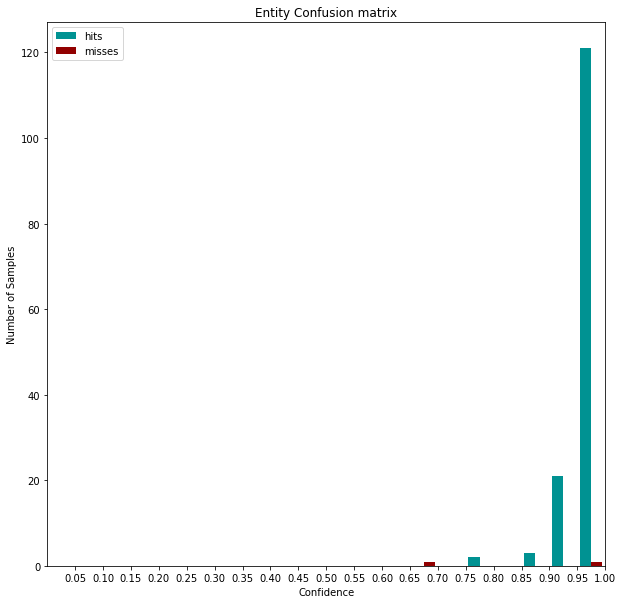

In [8]:
from rasa.nlu.test import run_evaluation

run_evaluation("data/nlu/nlu.yml", model_directory)

# 2. Teaching the bot to respond using Rasa Core

##  Visualising the Training Data

In [9]:
#!apt-get -qq install -y graphviz libgraphviz-dev pkg-config;
#!breq install graphviz

#!conda install -y -n rasa pygraphviz pkg-config;

In [10]:
from IPython.display import Image
from rasa.core.agent import Agent
 
agent = Agent('domain.yml')
agent.visualize("data/core/stories.yml", "story_graph.png", max_history=2)
Image(filename="story_graph.png")

## Training a Dialogue Model

In [9]:
from rasa.core.policies.policy import Policy
from rasa.core.policies.registry import RulePolicy, MemoizationPolicy
from rasa.core.agent import Agent

import asyncio

# this will catch predictions the model isn't very certain about
# there is a threshold for the NLU predictions as well as the action predictions
fallback = FallbackPolicy(fallback_action_name="utter_unclear",
                          core_threshold=0.2,
                          nlu_threshold=0.1)

agent = Agent('domain.yml',
              policies=[RulePolicy(),
                        MemoizationPolicy(max_history=5),
                        fallback])

# loading our neatly defined training dialogues
training_data = await agent.load_data('data/core/stories.yml')

agent.train(training_data)

agent.persist('./models/')

Processed story blocks: 100%|██████████| 30/30 [00:00<00:00, 55.92it/s, # trackers=50]
/home/debian/.conda/envs/rasa/lib/python3.7/site-packages/rasa/shared/utils/io.py:89: UserWarning: Found a rule-based policy in your pipeline but no rule-based training data. Please add rule-based stories to your training data or remove the rule-based policy (`RulePolicy`) from your your pipeline.
  More info at https://rasa.com/docs/rasa/rules
Processed trackers: 0it [00:00, ?it/s]
Processed trackers: 100%|██████████| 29/29 [00:00<00:00, 316.76it/s, # actions=147]
Processed actions: 147it [00:00, 2458.62it/s, # examples=143]


# Talk to your Bot

In [10]:
#Starting the Bot
from rasa.core.agent import Agent
from rasa.core.utils import EndpointConfig

action_endpoint = EndpointConfig(url="http://0.0.0.0:5055/webhook")
agent = Agent.load('./models/', interpreter=model_directory, action_endpoint=action_endpoint)

#!docker run -d -p 5055:5055 --mount type=bind,source=/home/debian/workspace/Dadbot/actions,target=/app/actions rasa/rasa-sdk

## Creating the voice synthesizer

In [17]:
#!git clone https://github.com/NVIDIA/tacotron2.git
#!git clone https://github.com/DeepLearningExamples/CUDA-Optimized/FastSpeech.git

from tensorboard.plugins.hparams import api as hp
from tacotron2.hparams import create_hparams
from tacotron2.model import Tacotron2
from tacotron2.stft import STFT
from tacotron2.audio_processing import griffin_lim
from tacotron2.train import load_model
from tacotron2.waveglow.mel2samp import files_to_list, MAX_WAV_VALUE
from tacotron2.waveglow.glow import WaveGlow
from fastspeech.inferencer.denoiser import Denoiser
from fastspeech.text_norm import text_to_sequence
import numpy as np
import torch
import sys
sys.path.append('tacotron2/waveglow/')

def synthesize(text, voice, sigma=0.6, denoiser_strength=0.05, is_fp16=False):

    hparams = create_hparams()
    hparams.sampling_rate = 22050

    if voice == "papaito":
        voice_model = "nvidia_tacotron2_papaito_300"
    elif voice == "constantino":
        voice_model = "tacotron2_Constantino_600"
    elif voice == "orador":
        voice_model = "checkpoint_tacotron2_29000_es"
    
    checkpoint_path = "/home/debian/workspace/models/" + voice_model
        
    model = load_model(hparams)
    model.load_state_dict(torch.load(checkpoint_path)['state_dict'])
    _ = model.cuda().eval().half()

    waveglow_path = '/home/debian/workspace/models/waveglow_256channels_ljs_v2.pt'
    waveglow = torch.load(waveglow_path)['model']
    _ = waveglow.cuda().eval().half()
    denoiser = Denoiser(waveglow)

    #text="¡Cágate lorito!"
    #with open(filelist_path, encoding='utf-8', mode='r') as f:
    #    text = f.read()

    sequence = np.array(text_to_sequence(text, ['english_cleaners']))[None, :]
    sequence = torch.autograd.Variable(
        torch.from_numpy(sequence)).cuda().long()

    mel_outputs, mel_outputs_postnet, _, alignments = model.inference(sequence)
    #mel = torch.unsqueeze(mel, 0)
    mel = mel_outputs.half() if is_fp16 else mel_outputs
    audio = np.array([])
    with torch.no_grad():
        audio = waveglow.infer(mel, sigma=sigma)
        if denoiser_strength > 0:
             audio = denoiser(audio, denoiser_strength)
        audio = audio * MAX_WAV_VALUE
        audio = audio.squeeze()
        audio = audio.cpu().numpy()
        audio = audio.astype('int16')
    
    return audio, hparams.sampling_rate

## Start chat

In [ ]:
import sounddevice as sd
from sty import fg, bg, ef, rs

print("¡Dadbot está listo para cascar! Escribe tus mensajes o dile 'quieto parao'")
while True:
    a = input()
    
    if a == 'quieto parao':
        break
    responses = await agent.handle_text(a)
    for response in responses:
        to_synth = response["text"]
        #to_synth = "Esto es una prueba para ver si funciona"
        print(fg.blue + to_synth + fg.rs)
        response_file = open('response.txt','w') 
        response_file.write(to_synth)
        # Voice synthesis commented due to tensorflow v1 incompatibilities
        voice, sr = synthesize(to_synth, "orador")
        sd.play(voice, sr)
        response_file.close()        

¡Dadbot está listo para cascar! Escribe tus mensajes o dile 'quieto parao'
hola
¡Eeeih! ¿qué dices?


/home/debian/.local/lib/python3.7/site-packages/torch/serialization.py:657: SourceChangeWarning: source code of class 'torch.nn.modules.conv.ConvTranspose1d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/home/debian/.local/lib/python3.7/site-packages/torch/serialization.py:657: SourceChangeWarning: source code of class 'torch.nn.modules.container.ModuleList' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/home/debian/.local/lib/python3.7/site-packages/torch/serialization.py:657: SourceChangeWarning: source code of class 'torch.nn.modules.conv.Conv1d' has changed. you can retrieve the original source code by accessing the o

¿cómo estás?
¿Qué tal?
muy bien
oye
¡Eeeih!
dime las noticias
Estas son las últimas noticias: Madrid, Castilla y León y La Rioja, las regiones con las UCI más saturadas porel coronavirus en España.
